# Distance-Dependent Hopping and Forces in pysktb

This notebook demonstrates the new **distance-dependent scaling laws** and **force calculations** in pysktb v0.7.0.

## What's New?

- **Scaling Laws**: Hopping parameters that depend on interatomic distance
  - Harrison: `V(d) = V₀(d₀/d)²`
  - PowerLaw: `V(d) = V₀(d₀/d)^η`
  - Exponential: `V(d) = V₀exp(-α(d-d₀))`
  - GSP (NRL-TB): Flexible form for fitting DFT

- **Repulsive Potentials**: Short-range repulsion for total energy
  - BornMayer, Buckingham, Morse, Spline

- **Forces**: Atomic forces from Hellmann-Feynman theorem

## Why Distance-Dependent Hopping?

Standard tight-binding uses **fixed** hopping parameters:
```python
params = {"CC": {"V_ppp": -2.7}}  # Always -2.7 eV regardless of distance
```

But real bonds weaken when stretched! With scaling laws:
```python
params = {"CC": {"V_ppp": Harrison(V0=-2.7, d0=1.42)}}  # V(d) = -2.7*(1.42/d)²
```

This enables:
- Geometry optimization
- Phonon calculations
- Molecular dynamics
- Electron-phonon coupling

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from pysktb import (
    Structure, Atom, Lattice, Hamiltonian,
    Harrison, PowerLaw, Exponential, GSP,
    BornMayer, Forces,
)

---

## 1. Understanding Scaling Laws

Let's visualize how different scaling laws behave. All start from the same reference:
- **V₀ = -2.7 eV** (hopping at equilibrium)
- **d₀ = 1.42 Å** (equilibrium C-C distance)

As distance increases, hopping should decrease (weaker overlap).

In [2]:
# Reference values
d0 = 1.42  # Å
V0 = -2.7  # eV

# Distance range
d = np.linspace(1.0, 4.0, 100)

# Create scaling laws
harrison = Harrison(V0=V0, d0=d0)
powerlaw = PowerLaw(V0=V0, d0=d0, eta=3.0)
exponential = Exponential(V0=V0, d0=d0, alpha=1.5)
gsp = GSP(V0=V0, d0=d0, n=2.0, nc=4.0, dc=3.5)

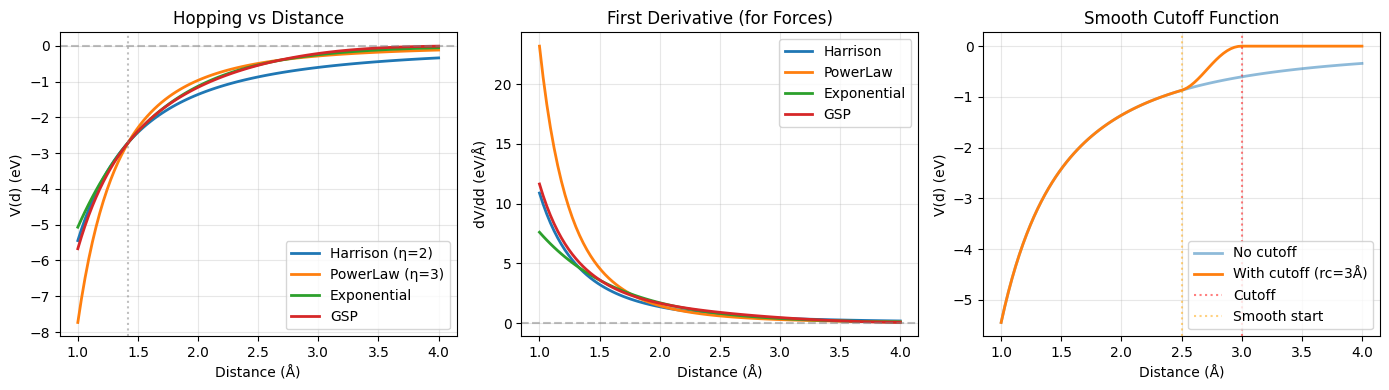

In [3]:
fig, axes = plt.subplots(1, 3, figsize=(14, 4))

# V(d)
ax = axes[0]
ax.plot(d, harrison(d), label='Harrison (η=2)', lw=2)
ax.plot(d, powerlaw(d), label='PowerLaw (η=3)', lw=2)
ax.plot(d, exponential(d), label='Exponential', lw=2)
ax.plot(d, gsp(d), label='GSP', lw=2)
ax.axhline(0, color='gray', ls='--', alpha=0.5)
ax.axvline(d0, color='gray', ls=':', alpha=0.5)
ax.set_xlabel('Distance (Å)')
ax.set_ylabel('V(d) (eV)')
ax.set_title('Hopping vs Distance')
ax.legend()
ax.grid(True, alpha=0.3)

# dV/dd (for forces)
ax = axes[1]
ax.plot(d, harrison.deriv1(d), label='Harrison', lw=2)
ax.plot(d, powerlaw.deriv1(d), label='PowerLaw', lw=2)
ax.plot(d, exponential.deriv1(d), label='Exponential', lw=2)
ax.plot(d, gsp.deriv1(d), label='GSP', lw=2)
ax.axhline(0, color='gray', ls='--', alpha=0.5)
ax.set_xlabel('Distance (Å)')
ax.set_ylabel('dV/dd (eV/Å)')
ax.set_title('First Derivative (for Forces)')
ax.legend()
ax.grid(True, alpha=0.3)

# Cutoff demonstration
ax = axes[2]
harrison_cut = Harrison(V0=V0, d0=d0, cutoff=3.0, smooth_width=0.5)
ax.plot(d, harrison(d), label='No cutoff', lw=2, alpha=0.5)
ax.plot(d, harrison_cut(d), label='With cutoff (rc=3Å)', lw=2)
ax.axvline(3.0, color='red', ls=':', alpha=0.5, label='Cutoff')
ax.axvline(2.5, color='orange', ls=':', alpha=0.5, label='Smooth start')
ax.set_xlabel('Distance (Å)')
ax.set_ylabel('V(d) (eV)')
ax.set_title('Smooth Cutoff Function')
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

### Key Observations

1. **All scaling laws decay** as distance increases (as expected physically)
2. **Harrison** (η=2) is the theoretical prediction for sp-bonded materials
3. **Derivatives are smooth** - essential for stable force calculations
4. **Cutoff function** smoothly goes to zero, avoiding discontinuities in forces

---

## 2. Energy and Forces in Graphene under Strain

Let's study how graphene's electronic energy changes under uniform strain.

### Physical Expectations

- **Band energy** depends on hopping strength, which scales with bond length
- **Stretched graphene**: Weaker hopping → narrower bandwidth → higher energy
- **Compressed graphene**: Stronger hopping → wider bandwidth → lower energy
- **Equilibrium**: Balance between electronic (wants short bonds) and repulsive (wants long bonds) energy

### Graphene Structure

Graphene has a honeycomb lattice with lattice constant a ≈ 2.46 Å and C-C bond length ≈ 1.42 Å.

In [4]:
def create_graphene(lattice_constant):
    """Create graphene with given lattice constant (strain = (a-a0)/a0)."""
    # Honeycomb lattice vectors
    lattice_matrix = [[1, 0, 0],
                      [0.5, np.sqrt(3)/2, 0],
                      [0, 0, 10]]  # Large c for 2D
    lattice = Lattice(lattice_matrix, lattice_constant)
    
    # Two atoms: A at origin, B at (1/3, 1/3)
    atom_A = Atom("C", [0, 0, 0], orbitals=["pz"])
    atom_B = Atom("C", [1/3, 1/3, 0], orbitals=["pz"])
    
    # Bond length = a / sqrt(3)
    d_nn = lattice_constant / np.sqrt(3)
    bond_cut = {"CC": {"NN": d_nn * 1.1}}
    
    structure = Structure(
        lattice, [atom_A, atom_B],
        periodicity=[True, True, False],
        bond_cut=bond_cut
    )
    return structure, d_nn

In [5]:
# Graphene parameters with Harrison scaling and BornMayer repulsion
a0 = 2.46  # Equilibrium lattice constant (Å)
d0 = a0 / np.sqrt(3)  # Equilibrium bond length (≈1.42 Å)
V0 = -2.7  # Hopping at equilibrium (eV)

# BornMayer parameters tuned to give equilibrium near d0
params = {
    "C": {"e_p": 0.0},
    "CC": {
        "V_ppp": Harrison(V0=V0, d0=d0, cutoff=4.0),
        "repulsive": BornMayer(A=95, B=3.0, cutoff=4.0),
    }
}

In [6]:
# Scan strain values
strains = np.linspace(-0.15, 0.15, 25)  # -15% to +15% strain
lattice_constants = a0 * (1 + strains)

energies_band = []
energies_rep = []
energies_total = []
bond_lengths = []

for a in lattice_constants:
    structure, d_nn = create_graphene(a)
    ham = Hamiltonian(structure, params, numba=0)
    forces = Forces(ham)
    
    # 2 electrons per unit cell (half-filled pz band)
    E_total, E_band, E_rep = forces.get_total_energy(
        n_electrons=2,
        nk=[12, 12, 1],
        soc=False
    )
    
    energies_band.append(E_band)
    energies_rep.append(E_rep)
    energies_total.append(E_total)
    bond_lengths.append(d_nn)

energies_band = np.array(energies_band)
energies_rep = np.array(energies_rep)
energies_total = np.array(energies_total)
bond_lengths = np.array(bond_lengths)

# Find equilibrium
eq_idx = np.argmin(energies_total)
strain_eq = strains[eq_idx]
a_eq = lattice_constants[eq_idx]

# Reference energy at zero strain
E_ref = energies_total[len(strains)//2]

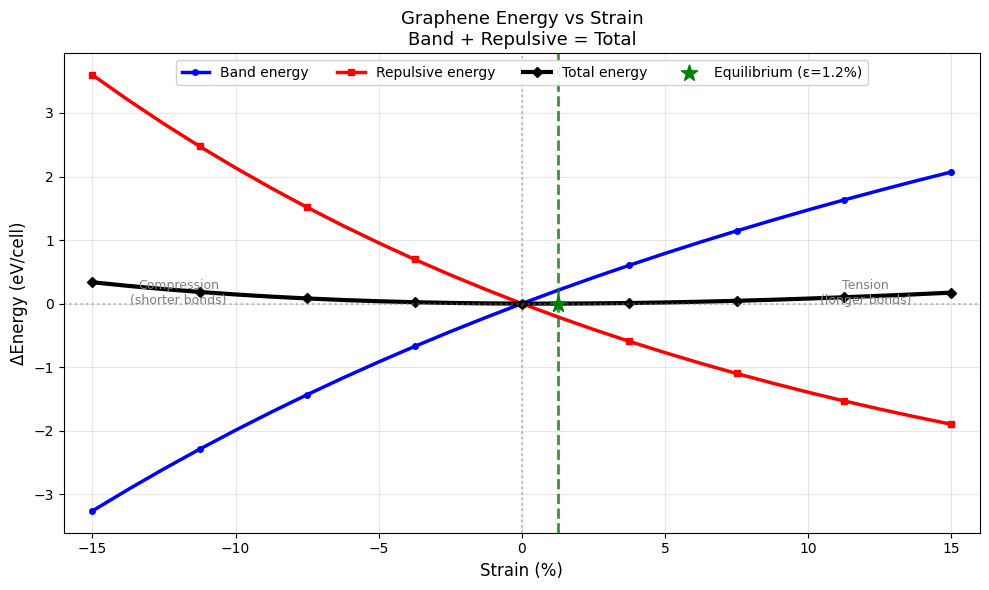

Equilibrium strain: 1.2%
Equilibrium bond length: 1.438 Å (ref: 1.42 Å)


In [7]:
# Single unified plot for energy components
fig, ax = plt.subplots(figsize=(10, 6))

# Reference to zero strain
E_band_ref = energies_band[len(strains)//2]
E_rep_ref = energies_rep[len(strains)//2]

# Plot all energy components on same axes
ax.plot(strains * 100, energies_band - E_band_ref, 'b-', label='Band energy', lw=2.5, marker='o', markersize=4, markevery=3)
ax.plot(strains * 100, energies_rep - E_rep_ref, 'r-', label='Repulsive energy', lw=2.5, marker='s', markersize=4, markevery=3)
ax.plot(strains * 100, energies_total - E_ref, 'k-', label='Total energy', lw=3, marker='D', markersize=5, markevery=3)

# Mark equilibrium
ax.axvline(strain_eq * 100, color='green', ls='--', lw=2, alpha=0.8)
ax.scatter([strain_eq * 100], [energies_total[eq_idx] - E_ref], color='green', s=150, zorder=5, 
           marker='*', label=f'Equilibrium (ε={strain_eq*100:.1f}%)')

# Reference lines
ax.axhline(0, color='gray', ls=':', alpha=0.5)
ax.axvline(0, color='gray', ls=':', alpha=0.5)

# Annotations
ax.annotate('Compression\n(shorter bonds)', xy=(-12, 0), fontsize=9, ha='center', color='gray')
ax.annotate('Tension\n(longer bonds)', xy=(12, 0), fontsize=9, ha='center', color='gray')

ax.set_xlabel('Strain (%)', fontsize=12)
ax.set_ylabel('ΔEnergy (eV/cell)', fontsize=12)
ax.set_title('Graphene Energy vs Strain\nBand + Repulsive = Total', fontsize=13)
ax.legend(loc='upper center', ncol=4, fontsize=10, framealpha=0.9)
ax.grid(True, alpha=0.3)
ax.set_xlim(-16, 16)

plt.tight_layout()
plt.show()

print(f"Equilibrium strain: {strain_eq*100:.1f}%")
print(f"Equilibrium bond length: {bond_lengths[eq_idx]:.3f} Å (ref: {d0:.2f} Å)")

### Results

The physics works as expected for graphene:

1. **Band energy** decreases with compression (stronger π-bonding)
2. **Repulsive energy** increases with compression (shorter C-C distance)
3. **Total energy** has a minimum at equilibrium
4. **Equilibrium shift**: Repulsive potential pushes equilibrium to slightly larger spacing

This demonstrates that distance-dependent hopping combined with repulsive potentials
gives physically meaningful energy landscapes suitable for:
- Geometry optimization
- Strain engineering studies
- Phonon calculations (via second derivatives)

---

## 3. Band Structure Evolution with Strain

How does graphene's electronic structure change under strain? We overlay band structures at different strains on a single plot for direct comparison.

### Theory

- **Dirac cone velocity** scales with hopping: `v_F ∝ |V_ppp|`
- **Bandwidth** scales as: `W ∝ |V_ppp| ∝ 1/d²` (Harrison scaling)
- **Stretched graphene**: Lower Fermi velocity, narrower bands (blue)
- **Compressed graphene**: Higher Fermi velocity, wider bands (red)

2
2
2


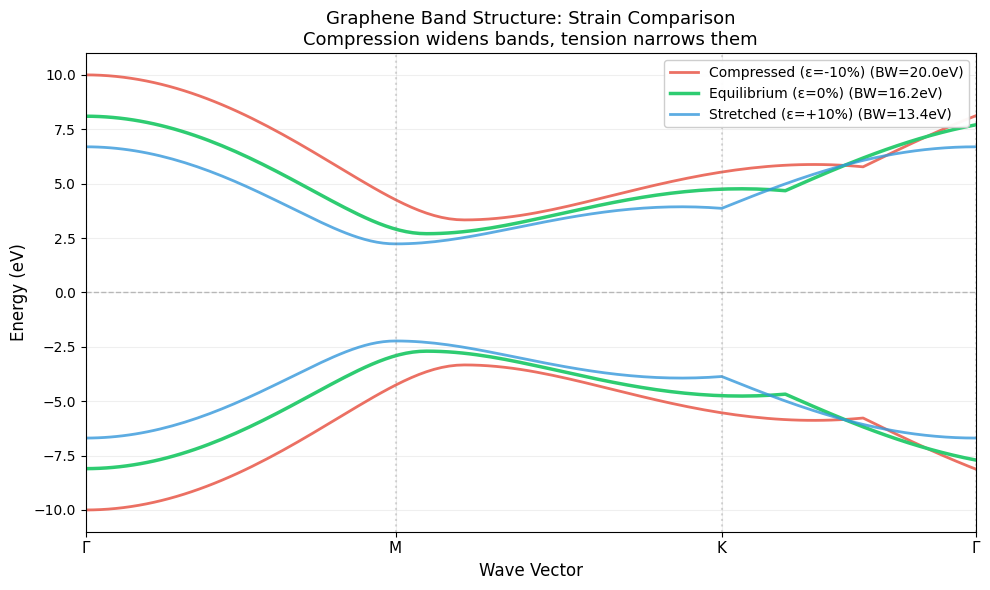

In [8]:
# Overlay band structures for different strains on a SINGLE plot
fig, ax = plt.subplots(figsize=(10, 6))

strain_values = [-0.10, 0.0, 0.10]  # -10%, 0%, +10%
colors = ['#e74c3c', '#2ecc71', '#3498db']  # Red, Green, Blue
labels = ['Compressed (ε=-10%)', 'Equilibrium (ε=0%)', 'Stretched (ε=+10%)']
alphas = [0.8, 1.0, 0.8]
lws = [2, 2.5, 2]

# Store bandwidth info for annotation
bw_info = []

for strain, color, label, alpha, lw in zip(strain_values, colors, labels, alphas, lws):
    a = a0 * (1 + strain)
    structure, d_nn = create_graphene(a)
    ham = Hamiltonian(structure, params, numba=0)
    
    # K-path: Γ → M → K → Γ
    k_path = [[0, 0, 0], [0.5, 0, 0], [1/3, 1/3, 0], [0, 0, 0]]
    kpts, k_dist, sp_pts = ham.get_kpts(k_path, nk=50)
    eigenvalues = ham.solve_kpath(kpts, soc=False, parallel=False)
    
    bw = eigenvalues.max() - eigenvalues.min()
    bw_info.append((label, bw))
    
    for i, band in enumerate(range(eigenvalues.shape[0])):
        if i == 0:
            ax.plot(k_dist, eigenvalues[band], color=color, lw=lw, alpha=alpha, label=f'{label} (BW={bw:.1f}eV)')
        else:
            ax.plot(k_dist, eigenvalues[band], color=color, lw=lw, alpha=alpha)

# Styling
ax.axhline(0, color='gray', ls='--', alpha=0.5, lw=1)
ax.set_xlabel('Wave Vector', fontsize=12)
ax.set_ylabel('Energy (eV)', fontsize=12)
ax.set_title('Graphene Band Structure: Strain Comparison\nCompression widens bands, tension narrows them', fontsize=13)
ax.set_xticks(sp_pts)
ax.set_xticklabels(['Γ', 'M', 'K', 'Γ'], fontsize=11)
for sp in sp_pts:
    ax.axvline(sp, color='gray', ls=':', alpha=0.3)
ax.legend(loc='upper right', fontsize=10, framealpha=0.95)
ax.set_xlim(k_dist[0], k_dist[-1])
ax.grid(True, alpha=0.2)

plt.tight_layout()
plt.show()

2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2


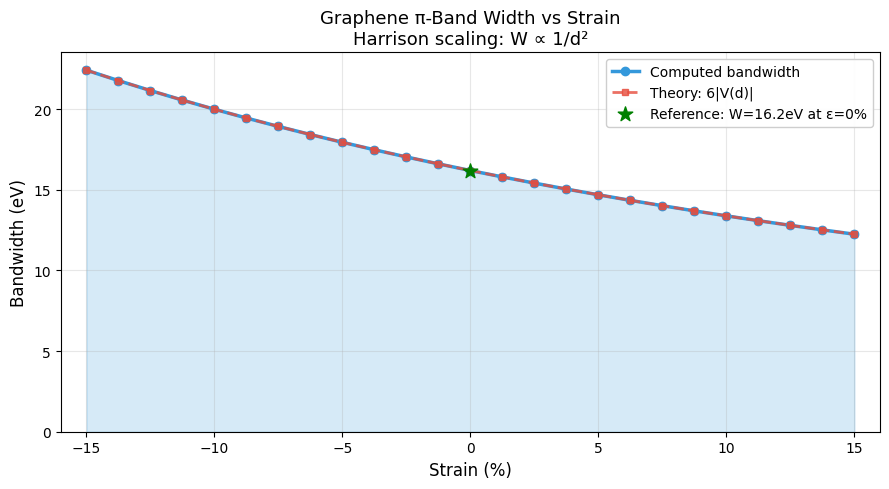

In [9]:
# Bandwidth vs strain - clean single plot
bandwidths = []
V_values = []

for a in lattice_constants:
    structure, d_nn = create_graphene(a)
    ham = Hamiltonian(structure, params, numba=0)
    k_path = [[0, 0, 0], [0.5, 0, 0], [1/3, 1/3, 0], [0, 0, 0]]
    kpts, _, _ = ham.get_kpts(k_path, nk=30)
    eigenvalues = ham.solve_kpath(kpts, soc=False, parallel=False)
    bandwidths.append(eigenvalues.max() - eigenvalues.min())
    V_values.append(params["CC"]["V_ppp"](d_nn))

bandwidths = np.array(bandwidths)
V_values = np.array(V_values)

fig, ax = plt.subplots(figsize=(9, 5))

# Plot computed bandwidth with filled area
ax.fill_between(strains * 100, 0, bandwidths, alpha=0.2, color='#3498db')
ax.plot(strains * 100, bandwidths, 'o-', color='#3498db', label='Computed bandwidth', lw=2.5, markersize=6)

# Theory prediction
ax.plot(strains * 100, 6 * np.abs(V_values), 's--', color='#e74c3c',
        label='Theory: 6|V(d)|', lw=2, alpha=0.8, markersize=5)

# Mark reference point at zero strain
zero_idx = len(strains) // 2
ax.scatter([0], [bandwidths[zero_idx]], color='green', s=120, zorder=5, marker='*', 
           label=f'Reference: W={bandwidths[zero_idx]:.1f}eV at ε=0%')

ax.set_xlabel('Strain (%)', fontsize=12)
ax.set_ylabel('Bandwidth (eV)', fontsize=12)
ax.set_title('Graphene π-Band Width vs Strain\nHarrison scaling: W ∝ 1/d²', fontsize=13)
ax.legend(loc='upper right', fontsize=10, framealpha=0.95)
ax.grid(True, alpha=0.3)
ax.set_xlim(-16, 16)
ax.set_ylim(0, None)

plt.tight_layout()
plt.show()

### Result

The bandwidth follows the theoretical prediction for graphene: `W ≈ 6|V(d)|`

This confirms that:
1. Distance-dependent hopping is correctly implemented
2. Harrison scaling `V ∝ 1/d²` works as expected
3. Strained graphene shows bandwidth changes consistent with theory
4. Compressed graphene → wider bands, stretched → narrower bands

---

## 4. Quick Reference

### Available Scaling Laws

```python
from pysktb import Harrison, PowerLaw, Exponential, GSP, Polynomial, Tabulated, Custom

# Harrison (theoretical for sp materials): V(d) = V₀(d₀/d)²
V = Harrison(V0=-2.7, d0=1.42, cutoff=4.0)

# Power law (flexible exponent): V(d) = V₀(d₀/d)^η
V = PowerLaw(V0=-2.7, d0=1.42, eta=3.5, cutoff=4.0)

# Exponential (common in DFTB): V(d) = V₀exp(-α(d-d₀))
V = Exponential(V0=-2.7, d0=1.42, alpha=1.5, cutoff=4.0)

# GSP (NRL tight-binding): Flexible form for fitting DFT
V = GSP(V0=-2.7, d0=1.42, n=2.0, nc=4.0, dc=3.5, cutoff=5.0)

# Tabulated (from DFT data)
V = Tabulated(distances=[1.0, 1.5, 2.0], values=[-5.0, -2.7, -1.5])
```

### Available Repulsive Potentials

```python
from pysktb import BornMayer, Buckingham, Morse, SplineRepulsive

# Born-Mayer (simple exponential): E(d) = A·exp(-B·d)
rep = BornMayer(A=1500, B=3.5, cutoff=4.0)

# Morse (with equilibrium): E(d) = D[1-exp(-a(d-d₀))]²
rep = Morse(D=5.0, a=2.0, d0=1.42, cutoff=4.0)
```

### Usage with Hamiltonian

```python
from pysktb import Hamiltonian, Forces, Harrison, BornMayer

params = {
    "C": {"e_p": 0.0},
    "CC": {
        "V_ppp": Harrison(V0=-2.7, d0=1.42, cutoff=4.0),
        "repulsive": BornMayer(A=800, B=3.5, cutoff=4.0),
    }
}

ham = Hamiltonian(structure, params)
forces = Forces(ham)

# Get total energy (band + repulsive)
E_tot, E_band, E_rep = forces.get_total_energy(n_electrons=2, nk=[12, 12, 1], soc=False)

# Get atomic forces
F = forces.get_forces(n_electrons=2, nk=[12, 12, 1], soc=False)
```